In [ ]:
import sys, os
if 'google.colab' in sys.modules:
    # mount google drive
    from google.colab import drive
    drive.mount('/content/drive')
    path_to_file = '/content/drive/Shareddrives/OASIS-1'
    print(path_to_file)
    # move to Google Drive directory
    os.chdir(path_to_file)
    !pwd

Mounted at /content/drive
/content/drive/Shareddrives/OASIS-1
/content/drive/Shareddrives/OASIS-1


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T
import torch.nn.functional as F

import numpy as np

USE_GPU = True
dtype = torch.float32
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print('using device:', device)

using device: cuda


(248, 496, 3)


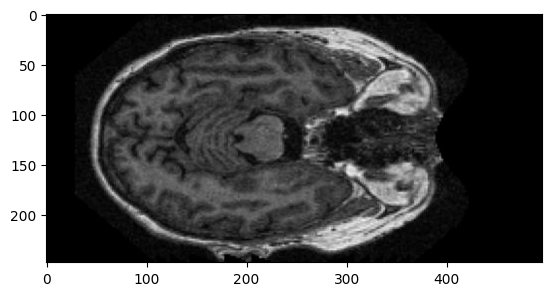

In [ ]:
import matplotlib.image as img
import matplotlib.pyplot as plt
# Healthy
image = img.imread('Non Demented/OAS1_0001_MR1_mpr-1_106.jpg')
print(image.shape)
plt.imshow(image)
plt.show()

In [ ]:
path_Non_Demented = []
path_veryMild = []
path_Mild_Moderate = []
for dirname, _, filenames in os.walk('Non Demented'):
    for filename in filenames:
        path_Non_Demented.append(os.path.join(dirname, filename))

for dirname, _, filenames in os.walk('Mild Dementia'):
    for filename in filenames:
        path_Mild_Moderate.append(os.path.join(dirname, filename))

for dirname, _, filenames in os.walk('Moderate Dementia'):
    for filename in filenames:
        path_Mild_Moderate.append(os.path.join(dirname, filename))

for dirname, _, filenames in os.walk('Very mild Dementia'):
    for filename in filenames:
        path_veryMild.append(os.path.join(dirname, filename))

In [ ]:
print(len(path_veryMild), len(path_Non_Demented), len(path_Mild_Moderate))

13725 15057 5492


**One Hot Encoder**
Assign label

In [ ]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
encoder.fit([[0],[1],[2]])

# 0 --> Non Demented
# 1 --> Very Mild Dementia
# 2+ --> Moderate Dementia/ Mild Dementia

OneHotEncoder()

**Define Pytorch dataset**

In [ ]:
#Define DataSet
import os
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset

class MRIDataset(Dataset):
    def __init__(self, file_paths, encoder, transform=None):
        self.file_paths = file_paths
        self.encoder = encoder
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img_path = self.file_paths[idx]
        img = Image.open(img_path)
        img = img.resize((128, 128))
        img = np.array(img)
        if img_path.startswith("Non Demented/"):
          encoder_index = 0
        elif img_path.startswith("Very mild Dementia"):
          encoder_index = 1
        elif img_path.startswith("Moderate Dementia") or img_path.startswith("Mild Dementia") :
          encoder_index = 2
        if img.shape == (128, 128, 3):
            plt.imshow(img)
            plt.show()
           # Transpose image dimensions into (3,128,128)
            img = np.transpose(img, (2, 0, 1))
            if self.transform:
                img = self.transform(img)
            label = self.encoder.transform([[encoder_index]]).toarray()
            return img, torch.tensor(label.squeeze(), dtype=torch.float32)
        else:
            return None


**Load each path seperatly, and then concatenate into one dataset**

In [ ]:
from sklearn.model_selection import train_test_split

#four lists of file paths
# Define the ratios for train, validation, and test sets

train_ratio = 0.6
val_ratio = 0.2
test_ratio = 0.2

train_imgs = []
val_imgs = []
test_imgs= []

# Iterate over each path, encoder, and label index
for paths in [path_Non_Demented, path_veryMild,path_Mild_Moderate]:
    # Split paths into train, validation, and test sets
    train_paths, remaining_paths = train_test_split(paths, test_size=val_ratio + test_ratio)
    val_paths, test_paths = train_test_split(remaining_paths, test_size=test_ratio / (val_ratio + test_ratio))
    train_imgs.extend(train_paths)
    val_imgs.extend(val_paths)
    test_imgs.extend(test_paths)

print(train_imgs)
print(len(train_imgs))
print(val_imgs)
print(len(val_imgs))
print(test_imgs)
print(len(test_imgs))


['Non Demented/OAS1_0007_MR1_mpr-2_146.jpg', 'Non Demented/OAS1_0040_MR1_mpr-1_157.jpg', 'Non Demented/OAS1_0014_MR1_mpr-1_102.jpg', 'Non Demented/OAS1_0050_MR1_mpr-1_148.jpg', 'Non Demented/OAS1_0078_MR1_mpr-3_132.jpg', 'Non Demented/OAS1_0030_MR1_mpr-2_125.jpg', 'Non Demented/OAS1_0079_MR1_mpr-4_138.jpg', 'Non Demented/OAS1_0069_MR1_mpr-1_104.jpg', 'Non Demented/OAS1_0027_MR1_mpr-3_125.jpg', 'Non Demented/OAS1_0030_MR1_mpr-4_160.jpg', 'Non Demented/OAS1_0007_MR1_mpr-1_130.jpg', 'Non Demented/OAS1_0045_MR1_mpr-1_139.jpg', 'Non Demented/OAS1_0012_MR1_mpr-1_132.jpg', 'Non Demented/OAS1_0014_MR1_mpr-2_110.jpg', 'Non Demented/OAS1_0011_MR1_mpr-2_130.jpg', 'Non Demented/OAS1_0080_MR1_mpr-3_108.jpg', 'Non Demented/OAS1_0074_MR1_mpr-1_122.jpg', 'Non Demented/OAS1_0054_MR1_mpr-4_116.jpg', 'Non Demented/OAS1_0033_MR1_mpr-2_101.jpg', 'Non Demented/OAS1_0087_MR1_mpr-4_139.jpg', 'Non Demented/OAS1_0090_MR1_mpr-1_132.jpg', 'Non Demented/OAS1_0061_MR1_mpr-1_114.jpg', 'Non Demented/OAS1_0061_MR2_mpr

In [ ]:
train_dataset = MRIDataset(train_imgs, encoder)
val_dataset = MRIDataset(val_imgs, encoder)
test_dataset = MRIDataset(test_imgs, encoder)
print(len(train_dataset), len(val_dataset), len(test_dataset))
print(type(train_dataset))

20564 6854 6856
<class '__main__.MRIDataset'>


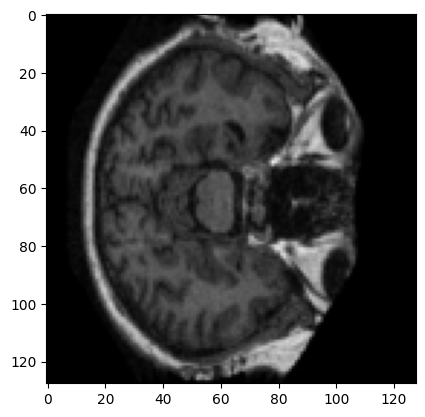

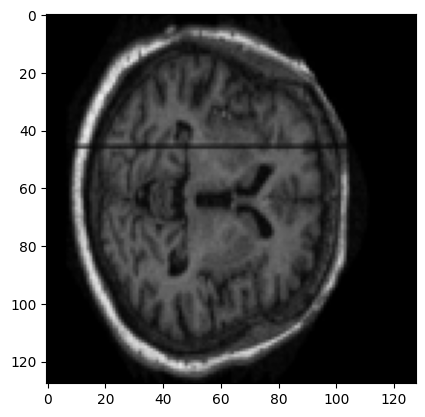

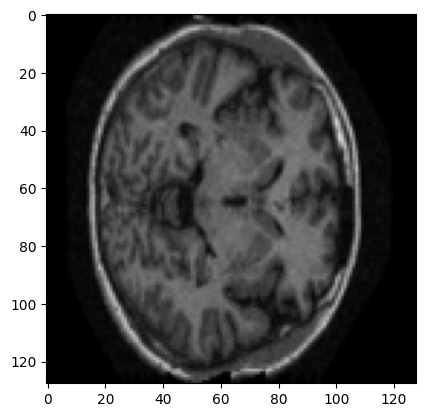

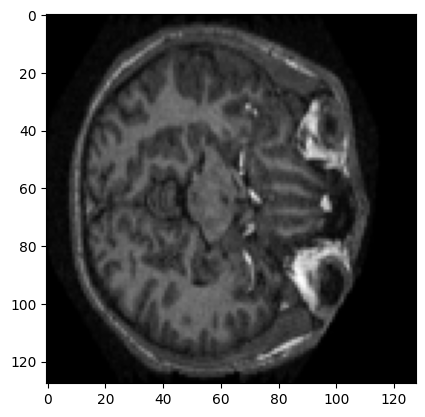

KeyboardInterrupt: 

In [ ]:
import torch
from torch.utils.data import DataLoader
batch_size = 10
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

for batch_idx, batch in enumerate(train_dataloader):
    if batch_idx >= 1:  # Check only the first 3 batches
        break
    images, labels = batch
    print("Batch", batch_idx + 1)
    print("Images:", images.shape)
    img = images[0]
    plt.imshow(img)
    plt.show()
    print("Labels:", labels.shape)

**Define 2D CNN model structure**

In [ ]:
import torch
import torch.nn as nn
from torchsummary import summary

model2DCNN = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=3, padding=1),
    nn.Conv2d(64, 64, kernel_size=3, padding=1),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(64, 128, kernel_size=3, padding=1),
    nn.Conv2d(128, 128, kernel_size=3, padding=1),
    nn.ReLU(),
    nn.BatchNorm2d(128),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Dropout(0.25),
    nn.Flatten(),
    nn.Linear(131072, 3),
    nn.Softmax(dim=1)
)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2DCNN.to(device)
summary(model2DCNN, input_size=(3,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,792
            Conv2d-2         [-1, 64, 128, 128]          36,928
         MaxPool2d-3           [-1, 64, 64, 64]               0
            Conv2d-4          [-1, 128, 64, 64]          73,856
            Conv2d-5          [-1, 128, 64, 64]         147,584
              ReLU-6          [-1, 128, 64, 64]               0
       BatchNorm2d-7          [-1, 128, 64, 64]             256
         MaxPool2d-8          [-1, 128, 32, 32]               0
           Dropout-9          [-1, 128, 32, 32]               0
          Flatten-10               [-1, 131072]               0
           Linear-11                    [-1, 3]         393,219
          Softmax-12                    [-1, 3]               0
Total params: 653,635
Trainable params: 653,635
Non-trainable params: 0
-------------------------------

In [ ]:
pip install torchinfo

**2D CNN + LSTM Model structure**

In [ ]:
import torch
import torch.nn as nn
from torchinfo import summary


class Hybrid2DModel(nn.Module):
    def __init__(self):
        super(Hybrid2DModel, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.lstm_input_size = 128 * 32 * 32  # Adjust this based on the size of the output from the conv layers
        self.lstm = nn.LSTM(input_size=self.lstm_input_size, hidden_size=49, batch_first=True)
        self.fc = nn.Linear(49, 3)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
      x = self.conv_layers(x)
      batch_size = x.shape[0]
      x = x.view(batch_size, 1, -1)
      x, _ = self.lstm(x)
      x = x[:, -1, :]
      x = self.fc(x)
      x = self.softmax(x)
      return x

# Create an instance of the model
modelHybrid = Hybrid2DModel()
summary(modelHybrid, (1, 3, 128, 128))


Layer (type:depth-idx)                   Output Shape              Param #
MyModel                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 128, 32, 32]          --
│    └─Conv2d: 2-1                       [1, 64, 128, 128]         1,792
│    └─Conv2d: 2-2                       [1, 64, 128, 128]         36,928
│    └─MaxPool2d: 2-3                    [1, 64, 64, 64]           --
│    └─Conv2d: 2-4                       [1, 128, 64, 64]          73,856
│    └─Conv2d: 2-5                       [1, 128, 64, 64]          147,584
│    └─ReLU: 2-6                         [1, 128, 64, 64]          --
│    └─BatchNorm2d: 2-7                  [1, 128, 64, 64]          256
│    └─MaxPool2d: 2-8                    [1, 128, 32, 32]          --
├─LSTM: 1-2                              [1, 1, 49]                25,700,108
├─Linear: 1-3                            [1, 3]                    150
├─Softmax: 1-4                           [1, 3]            

In [ ]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score, balanced_accuracy_score, roc_auc_score
def check_accuracy(loader, model, isTrain=True):
    if isTrain:
        print('Checking accuracy on validation set')
    else:
        print('Checking accuracy on test set')
    num_correct = 0
    num_samples = 0
    model.eval()
    all_predictions_balanced = []
    all_predictions_roc = []
    all_labels = []
    with torch.no_grad():
        loader_size = len(loader)
        print("Size of DataLoader:", loader_size)
        print(device)
        for t, (x, y) in enumerate(loader):
          print("validation iteration %d" % (t))
          x = x.to(device=device, dtype=dtype)
          y = y.to(device=device, dtype=torch.long)
          scores = model(x)
          _, preds = scores.max(1)
          # Convert one-hot encoded labels to class indices
          if y.dim() > 1:
            y = torch.argmax(y, dim=1)

          #compute accuracy
          num_correct += (preds == y).sum()
          num_samples += preds.size(0)

          #balanced accuracy
          all_predictions_balanced.extend(preds.cpu().numpy())
          all_labels.extend(y.cpu().numpy())

          #roc
          probabilities = torch.softmax(scores, dim=1)
          all_predictions_roc.extend(probabilities.cpu().numpy())


        acc = float(num_correct) / num_samples
        balanced_acc = balanced_accuracy_score(all_labels, all_predictions_balanced)
        roc_acc = roc_auc_score(all_labels, all_predictions_roc, multi_class='ovr')
        print('Got %d / %d Accuracy (%.2f)' % (num_correct, num_samples, 100 * acc))
        print('Got %d / %d Balanced Accuracy (%.2f)' % (num_correct, num_samples, 100 * balanced_acc))
        print('Got %d / %d ROC Accuracy (%.2f)' % (num_correct, num_samples, 100 * roc_acc))
        return acc, balanced_acc, roc_acc

In [ ]:
train_loss_history = []
accuracy_history = []
balanced_accuracy_history = []
roc_history = []

In [ ]:
import torch.nn.functional as F

def train(model, optimizer, epochs=1):
    model = model.to(device=device)

    for e in range(epochs):
      epoch_loss = 0.0
      print("Current epoch %d" % (e))
      for t, (x, y) in enumerate(train_dataloader):
        #print("this is current iteration %d" % (t))
        model.train()
        x = x.to(device=device, dtype=dtype)
        y = y.to(device=device, dtype=torch.long)

        scores = model(x)
        class_indices = torch.argmax(y, dim=1)
        loss = F.cross_entropy(scores, class_indices)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # epoch_loss += loss.item()
        # train_loss_history.append(loss.item())

        if t % print_every == 0:
          print('Iteration %d, loss = %.4f' % (t, loss.item()))
          accuracy, balanced_accuracy, roc_accuracy = check_accuracy(val_dataloader, model, True)
          accuracy_history.append(accuracy)
          balanced_accuracy_history.append(balanced_accuracy)
          roc_history.append(roc_accuracy)
          train_loss_history.append(loss.item())

      avg_epoch_loss = epoch_loss / len(train_dataloader)
      #Store training loss for this epoch
      train_loss_history.append(avg_epoch_loss)

In [ ]:
#Define optimizer
learning_rate=1e-2
model1 = MyModel()
optimizer = optim.SGD(model.parameters(), lr=learning_rate,
                     momentum=0.9, nesterov=True)
print_every = 5
train_part34(model, optimizer, epochs =5)

In [ ]:
#Plot the loss
plt.plot(train_loss_history, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Plot')
plt.legend()
plt.show()

print(len(train_loss_history))

In [ ]:
#Plot the accuracy
plt.plot([50 * i for i in range(len(accuracy_history))], accuracy_history,label='Validation Accuracy')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy')
plt.legend()
plt.show()
print(accuracy_history)

In [ ]:
#Plot the Balanced Accuracy
plt.plot([50 * i for i in range(len(balanced_accuracy_history))], balanced_accuracy_history, label='Validation Balanced Accuracy')
plt.xlabel('Iteration')
plt.ylabel('Balanced Accuracy')
plt.title('Validation Balanced Accuracy')
plt.legend()
plt.show()

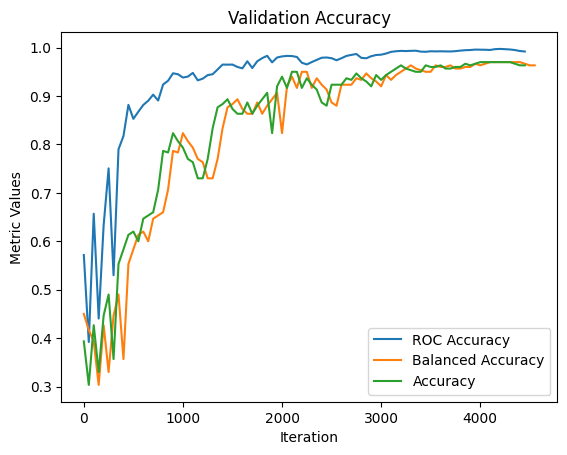

In [ ]:
#Plot the ROC
plt.plot([50 * i for i in range(len(roc_history))],roc_history, label='ROC Accuracy')
plt.plot([50 * i for i in range(len(balanced_accuracy_history))], balanced_accuracy_history, label='Balanced Accuracy')
plt.plot([50 * i for i in range(len(accuracy_history))], accuracy_history,label='Accuracy')
plt.xlabel('Iteration')
plt.ylabel('Metric Values')
plt.title('Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
best_model = model
check_accuracy_part34(test_dataloader, best_model, False)

Checking accuracy on test set
Size of DataLoader: 30
cuda
validation iteration 0
validation iteration 1
validation iteration 2
validation iteration 3
validation iteration 4
validation iteration 5
validation iteration 6
validation iteration 7
validation iteration 8
validation iteration 9
validation iteration 10
validation iteration 11
validation iteration 12
validation iteration 13
validation iteration 14
validation iteration 15
validation iteration 16
validation iteration 17
validation iteration 18
validation iteration 19
validation iteration 20
validation iteration 21
validation iteration 22
validation iteration 23
validation iteration 24
validation iteration 25
validation iteration 26
validation iteration 27
validation iteration 28
validation iteration 29
Got 295 / 300 Accuracy (98.33)
Got 295 / 300 Balanced Accuracy (98.33)
Got 295 / 300 ROC Accuracy (99.08)


(0.9833333333333333, 0.9833333333333334, 0.9907666666666666)